In [81]:
%%capture
!pip install rdkit
!pip install torch_geometric

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import networkx as nx
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.Draw import IPythonConsole
# from tqdm import tqdm

import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

In [83]:
import os
import random
from collections import Counter

import torch

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [84]:
# print(plt.style.available)
plt.style.use('ggplot')

In [85]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [86]:
seed_set()

## **Loading Dataset**

In [87]:
df = pd.read_csv('Lipophilicity.csv')

In [88]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


## **Data Analysis**

In [89]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [90]:
# make sure there are no duplicates
df['smiles'].nunique()

4200

Text(0, 0.5, 'Count')

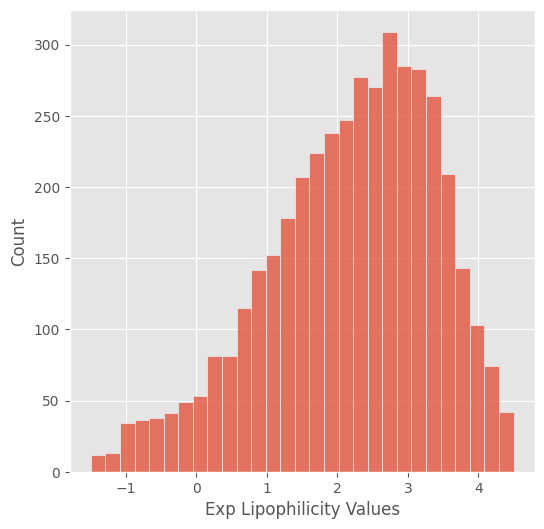

In [91]:
# distribution of exp lipophilicity values

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='exp', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Exp Lipophilicity Values')
plt.ylabel('Count')

In [92]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')

In [93]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7b52049b82e0>
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8430>
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8350>
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b83c0>
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b84a0>


In [94]:
mwt = []
for mol in df['mol']:
  MW = Descriptors.MolWt(mol)
  mwt.append(MW)

df['molwt'] = mwt

In [95]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7b52049b82e0>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8430>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8350>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b83c0>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b84a0>,381.480


Text(0, 0.5, 'Count')

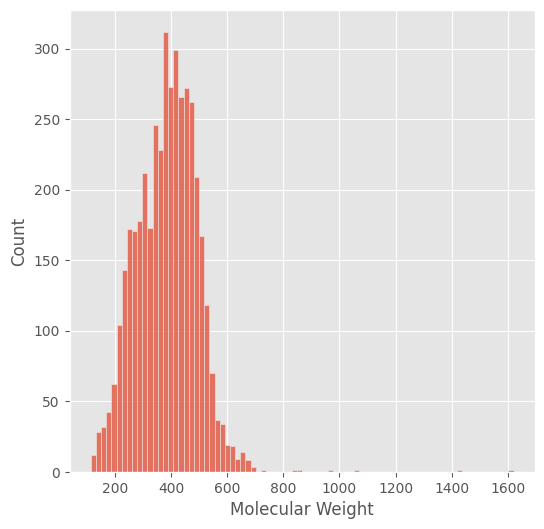

In [96]:
# Distribution of Molecular Weight in Raw Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [97]:
high_mwt = df[df['molwt'] > 700]
high_mwt

,CMPD_CHEMBLID,exp,smiles,mol,molwt
364,CHEMBL1094250,3.48,C[C@@H](CNC(=O)c1c(O)c(O)cc2c(O)c(c(C)cc12)c3c...,<rdkit.Chem.rdchem.Mol object at 0x7b5204a7a340>,700.788
442,CHEMBL1214185,1.80,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,<rdkit.Chem.rdchem.Mol object at 0x7b5204a7c5f0>,837.058
905,CHEMBL443684,0.64,CC1(C)CCC(=C(CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7b520528d230>,974.634
1236,CHEMBL2170837,4.20,CCn1c(C)c(C(=O)O)c(c2cccc(c2)N3CCN(CC3)c4ccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7b5205296420>,1065.703
1397,CHEMBL1200558,-0.46,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,<rdkit.Chem.rdchem.Mol object at 0x7b520529ab20>,1422.720
1646,CHEMBL3545252,3.40,O.O.O.CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b52052a1930>,861.935
3592,CHEMBL387675,-0.94,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7b52052d73e0>,1620.693
3780,CHEMBL163,4.30,CC(C)[C@H](NC(=O)N(C)Cc1csc(n1)C(C)C)C(=O)N[C@...,<rdkit.Chem.rdchem.Mol object at 0x7b52052dc740>,720.962


In [98]:
high_mwt.shape

(8, 5)

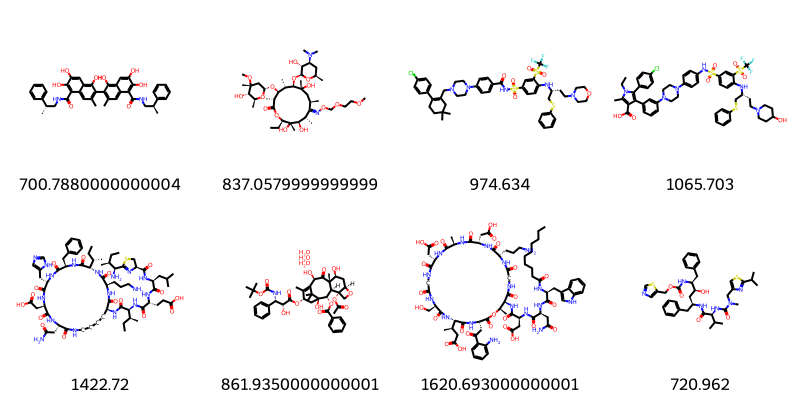

In [99]:
img=Draw.MolsToGridImage(high_mwt['mol'], molsPerRow=4, subImgSize=(200,200),legends=[str(x) for x in high_mwt['molwt']])
img

In [100]:
smiles = high_mwt['smiles']
df_final = df[~df['smiles'].isin(smiles)]

In [101]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7b52049b82e0>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8430>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8350>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b83c0>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b84a0>,381.480


In [102]:
df_final.shape

(4192, 5)

In [103]:
# df_final = df_final[['CMPD_CHEMBLID', 'exp', 'smiles']]
# df_final.to_csv('Lipophilicity_final.csv', index=None)

Text(0, 0.5, 'Count')

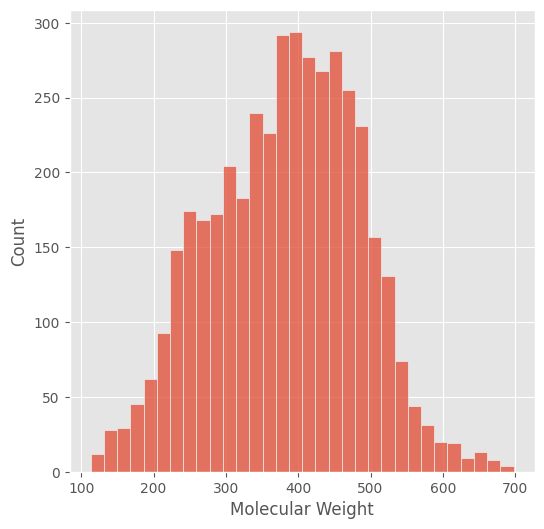

In [104]:
# Distribution of Molecular Weight in Truncated Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df_final, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [105]:
df_final = df_final.reset_index(drop=True)

In [106]:
df_final.describe()

,exp,molwt
count,4192.000000,4192.000000
mean,2.186591,381.915338
std,1.201077,102.456833
min,-1.500000,113.160000
25%,1.410000,306.440750
50%,2.360000,388.370500
75%,3.100000,456.576500
max,4.500000,697.778000


In [107]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7b52049b82e0>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8430>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7b52049b8350>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b83c0>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7b52049b84a0>,381.480


In [108]:
unique_atoms = set()
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    unique_atoms.add(a)

In [109]:
unique_atoms

{'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si'}

In [110]:
atom_list = []
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    atom_list.append(a)

In [111]:
Counter(atom_list)

Counter({'C': 83065,
         'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1})

In [112]:
dict_ = { 'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1}

In [113]:
df_freq = pd.DataFrame(dict_.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

In [114]:
df_freq.head()

,Atoms,Count
0,N,14505
2,O,10679
4,F,1760
3,S,1580
1,Cl,1288


<ipython-input-115-f894340493f7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')


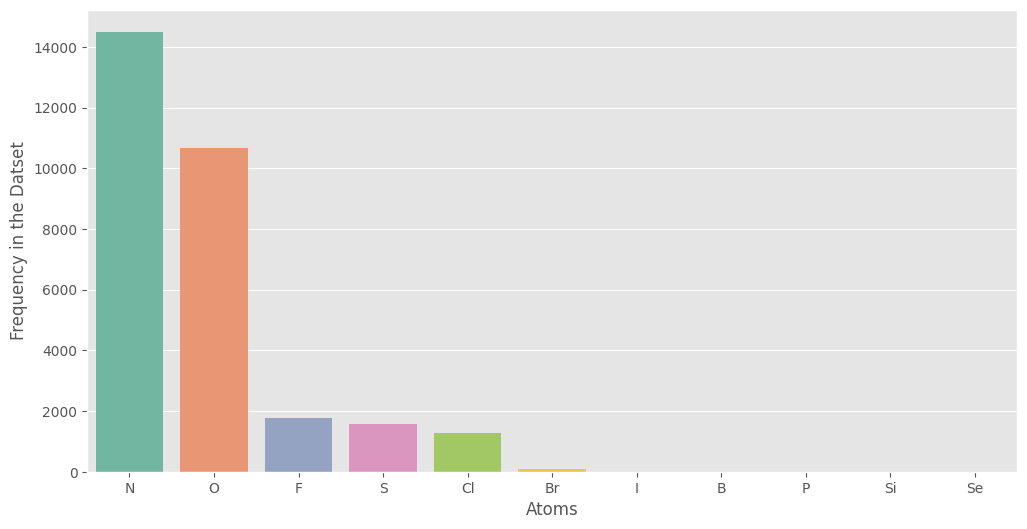

In [115]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Frequency in the Datset')
plt.show()

In [116]:
# b_mols = [Chem.MolFromSmiles(x) for x in b_smiles[-50:]]
# img=Draw.MolsToGridImage(b_mols,molsPerRow=4,subImgSize=(400,400))
# img

In [117]:
atom_list = ['B', 'Br','Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']
dict_2 = {}
for i in range(len(atom_list)):
  count=0
  for mol in df_final["mol"]:
    all_atoms = set()
    for atom in mol.GetAtoms():
      a = atom.GetSymbol()
      all_atoms.add(a)
    if atom_list[i] in all_atoms:
      count+=1
    dict_2[atom_list[i]] = count

In [118]:
dict_2

{'B': 6,
 'Br': 96,
 'Cl': 974,
 'F': 899,
 'I': 4,
 'N': 4039,
 'O': 3814,
 'P': 3,
 'S': 1352,
 'Se': 1,
 'Si': 1}

In [119]:
df_freq_2 = pd.DataFrame(dict_2.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

<ipython-input-120-44274c9ec8a9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')


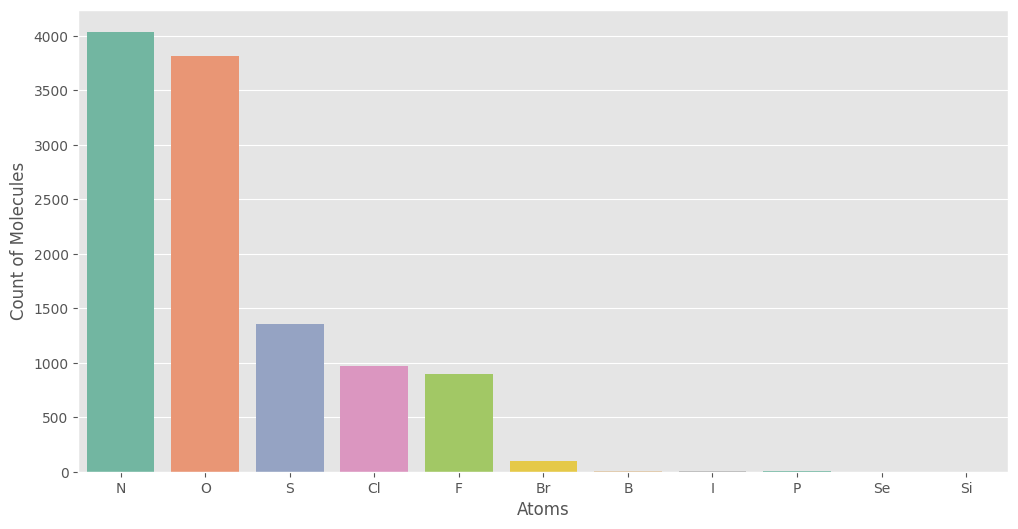

In [120]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Count of Molecules')
plt.show()

## **Generating and Analyzing Graphs**

In [121]:
df_final = pd.read_csv('Lipophilicity_final.csv')

In [122]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [123]:
smile = df_final['smiles'][92]

In [124]:
smile

'CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1'

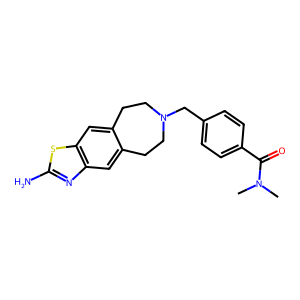

In [125]:
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [126]:
g = from_smiles(smile, with_hydrogen=False)
g

Data(x=[27, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1')

In [127]:
# type(g)

In [128]:
g.x.dtype

torch.int64

In [129]:
g.x

tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  3,  5,  2,  0,  3,  0,  0],
        [16,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  

In [130]:
g.num_nodes

27

In [131]:
g.num_node_features

9

In [132]:
g.edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  8,  8,
          8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 15,
         16, 16, 17, 17, 17, 18, 19, 19, 20, 20, 20, 21, 21, 22, 22, 22, 23, 23,
         24, 24, 25, 25, 26, 26],
        [ 1,  0,  2,  3,  1,  1,  4,  5,  3,  3,  6, 26,  5,  7,  6,  8,  7,  9,
         25,  8, 10,  9, 11, 24, 10, 12, 11, 13, 12, 14, 22, 13, 15, 14, 16, 20,
         15, 17, 16, 18, 19, 17, 17, 20, 15, 19, 21, 20, 22, 13, 21, 23, 22, 24,
         10, 23,  8, 26,  5, 25]])

In [133]:
g.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [1

In [134]:
g

Data(x=[27, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1')

In [135]:
G = to_networkx(g)

In [136]:
type(G)

networkx.classes.digraph.DiGraph

In [137]:
G.number_of_nodes()

27

In [138]:
list(G.nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [139]:
G.number_of_edges()

60

In [140]:
list(G.edges)

[(0, 1),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 1),
 (3, 1),
 (3, 4),
 (3, 5),
 (4, 3),
 (5, 3),
 (5, 6),
 (5, 26),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (8, 25),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (10, 24),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (13, 22),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (15, 20),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (17, 19),
 (18, 17),
 (19, 17),
 (19, 20),
 (20, 15),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 13),
 (22, 21),
 (22, 23),
 (23, 22),
 (23, 24),
 (24, 10),
 (24, 23),
 (25, 8),
 (25, 26),
 (26, 5),
 (26, 25)]

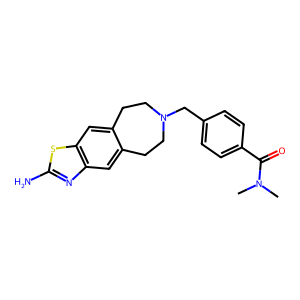

In [141]:
img

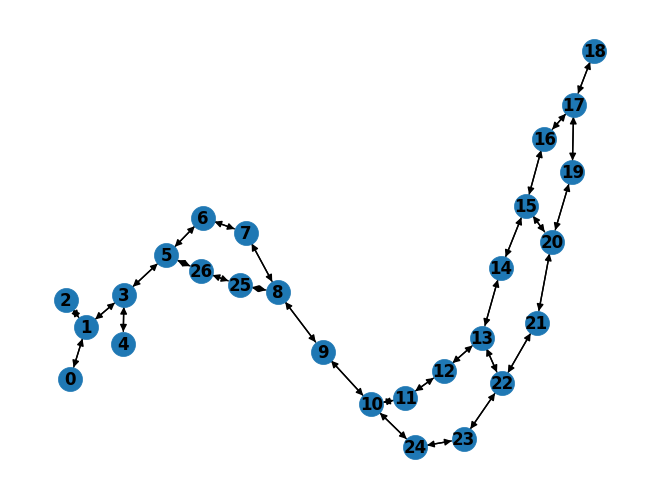

In [142]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.savefig("G.png")

# **Generate Graphs for the Whole Dataset**

In [143]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [144]:
graph_list = []
for i, smile in enumerate(df_final['smiles']):
  g = from_smiles(smile)
  g.x = g.x.float()
  y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
  g.y = y
  graph_list.append(g)

In [145]:
type(graph_list[0])

torch_geometric.data.data.Data

In [146]:
graph_list[1]

Data(x=[33, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', y=[1, 1])

In [147]:
graph_list[1].y

tensor([[-1.1800]])

In [148]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'Lipophilicity.csv'

    @property
    def processed_file_names(self):
        return 'data.dt'

    def download(self):
        # Download to `self.raw_dir`.
        # download_url(url, self.raw_dir)
        pass

    def process(self):
        # Read data into huge `Data` list.
        graph_list = []
        for i, smile in enumerate(df_final['smiles']):
          g = from_smiles(smile)
          g.x = g.x.float()
          y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
          g.y = y
          graph_list.append(g)


        data_list = graph_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [149]:
lipo = MyOwnDataset(root = '/content/')

Processing...
Done!


In [150]:
type(lipo)

__main__.MyOwnDataset

In [151]:
lipo[23]


Data(x=[31, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OC(=O)c1cccc(c1)N2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c4)CC2', y=[1, 1])

In [152]:
lipo[23].y

tensor([[2.1700]])

In [153]:
len(lipo)

4192

## **Train Test Split**

In [154]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(graph_list, [train_size, test_size], generator=generator1)

In [155]:
df_final.iloc[train_dataset.indices]

,CMPD_CHEMBLID,exp,smiles
3654,CHEMBL424451,3.96,COc1ccc(C)c(NC(=O)CC23CC4CC(CC(C4)C2)C3)c1
195,CHEMBL139347,2.40,Nc1nc(N)nc(n1)c2cccc(c2)C(F)(F)F
1988,CHEMBL2158833,1.10,OC(=O)c1ccc(CN2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c...
242,CHEMBL1201373,1.07,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...
310,CHEMBL1800526,2.92,COc1ccnc(CCc2nc3cc(Br)cnc3[nH]2)c1
...,...,...,...
1157,CHEMBL70824,2.16,CN(C)CCCN(C)S(=O)(=O)c1ccc(Nc2nccc(n2)c3cnc4cc...
829,CHEMBL211631,0.49,COc1cccc2c(ccnc12)c3c(C)n(CC(=O)O)c4ccc(C)cc34
40,CHEMBL168899,1.40,OB1N(C(=O)Nc2ccccc12)c3ccccc3
3768,CHEMBL1500992,3.20,O=C(CSc1ccccc1)N2CCN(CC2)c3ccccc3


In [156]:
test = df_final.iloc[test_dataset.indices]
test.to_csv('test_set.csv', index=None)

In [157]:
len(train_dataset)

3353

In [158]:
len(test_dataset)

839

In [159]:
train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=96)

In [160]:
type(train_loader)

torch_geometric.loader.dataloader.DataLoader

In [161]:
len(list(train_loader))

35

## **Defining Model**

In [162]:
graph_list[0]

Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
#                     edge_dim=3, num_layers=4, num_timesteps=2,
#                     dropout=0.2).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
#                              weight_decay=10**-5)

model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=6, num_timesteps=2,
                    dropout=0.0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,
                             weight_decay=0.0003126662000605776)

In [164]:
print(model)

AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1, edge_dim=3, num_layers=6, num_timesteps=2)


## **Train and Test Functions**

In [165]:
def train():
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    return sqrt(total_loss / total_samples)

In [166]:
@torch.no_grad()
def test(loader):
    mse = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,data.batch)
        l = F.mse_loss(out, data.y, reduction='none').cpu()
        mse.append(l)
    rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    return rmse

## **Model Training**

In [ ]:
score_train = []
score_test = []
epochs = 75
model.reset_parameters()
for epoch in range(epochs):
    train_rmse = train()
    test_rmse = test(test_loader)
    score_train.append(train_rmse)
    score_test.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_rmse:.4f} '
          f'Test Loss: {test_rmse:.4f}')
plt.plot(range(epochs), score_train, c='goldenrod')
plt.plot(range(epochs), score_test, c = 'blue')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['train', 'test'])

## **Model Evaluation**

In [168]:
@torch.no_grad()
def eval(loader):
    output = []
    smi = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)
        smi.append(data.smiles)

    # Stack the tensors along batch dimension
    stacked_output = torch.cat(output, dim=0)
    stacked_smiles = np.concatenate(smi)
    results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    r2 = r2_score(results['actual'], results['pred'])
    print(f"The R2 score is {r2}")
    return results



In [194]:
test_res = eval(test_loader)

The R2 score is 0.6817198030895982


In [195]:
test_res.head()

,pred,actual,smiles
0,2.283140,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,2.441888,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,0.687409,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.285578,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.519674,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [196]:
np.sqrt(mean_squared_error(test_res['actual'], test_res['pred']))

0.66323

In [197]:
train_res = eval(train_loader)

The R2 score is 0.82088046865855


In [198]:
train_res.head()

,pred,actual,smiles
0,3.181251,3.23,CN1CCN(CC1)c2ccc3ncc(C(=O)N)c(Nc4ccc(Cl)cc4Cl)...
1,2.999793,2.82,Cc1ccc(cc1)S(=O)(=O)Nc2ccc(\C=C\C(=O)Nc3ccccc3...
2,2.663525,2.51,CC(=O)N1CCN(CC1)c2ccc(NC(=O)c3oc(Nc4ccccc4F)nn...
3,1.329958,1.88,O=C1C(=O)c2cccnc2c3ccccc13
4,2.562599,2.50,Cc1cc(nc(n1)n2ccnc2)N3CCC[C@@H]3C(=O)NCCc4ccc5...


In [199]:
np.sqrt(mean_squared_error(train_res['actual'], train_res['pred']))

0.51085865

In [175]:
torch.save(model, '/content/model_lipo_tuned.pth')

In [193]:
model = torch.load('/content/model_lipo_tuned.pth')

## **Post-hoc Analysis**

In [200]:
test_res = eval(test_loader)

The R2 score is 0.6817198030895982


In [201]:
test_res.head()

,pred,actual,smiles
0,2.283140,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,2.441888,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,0.687409,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.285578,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.519674,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [202]:
train_res = eval(train_loader)

The R2 score is 0.82088046865855


In [203]:
train_res.head()

,pred,actual,smiles
0,2.883483,2.66,O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCc4[n...
1,1.279591,1.14,Clc1ccc(cc1)S(=O)(=O)Nc2nnc(s2)c3ccccc3
2,1.585365,0.22,NC(=O)c1cncc(c1)c2ccc(cc2)[C@@H]3CC[C@@H](CC(=...
3,1.402895,1.70,CC1=NC(C)(N=C1N)c2cccc(c2)c3cccnc3
4,2.142623,0.42,CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(c...


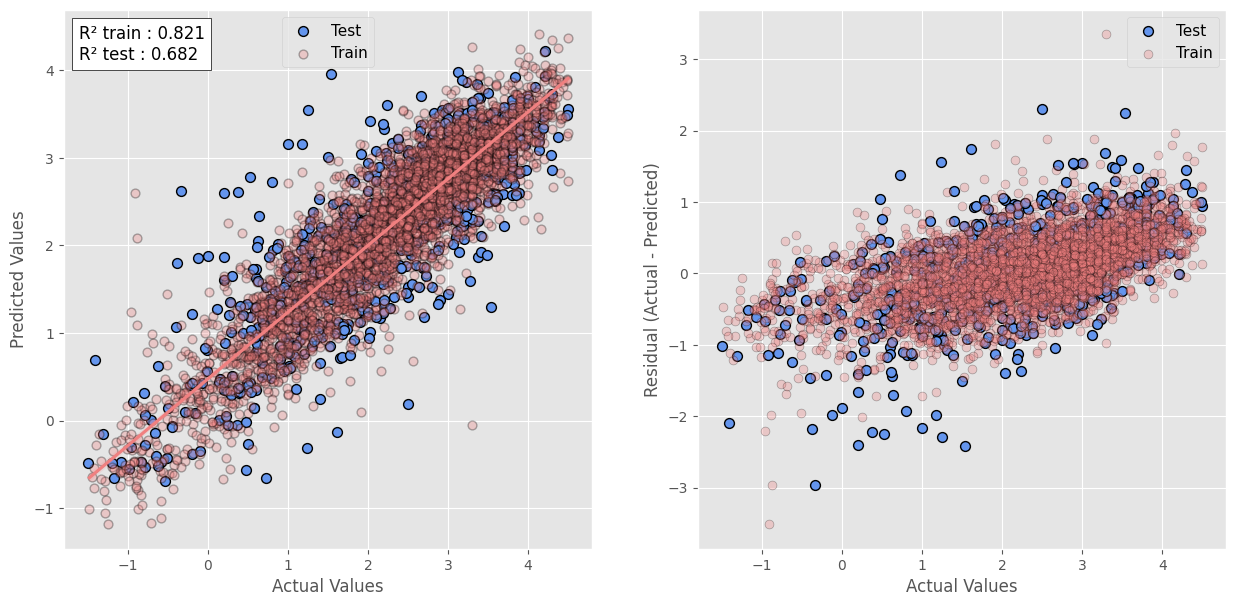

In [204]:
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
plt.scatter(test_res['actual'],test_res['pred'], color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.regplot(data = train_res, x = 'actual',y = 'pred', color='lightcoral', label='Train', scatter_kws={'s':40, 'alpha':0.3, 'edgecolor':'black'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
anchored_text = AnchoredText("R\u00b2 train : "+str(round(r2_score(train_res['actual'],train_res['pred']),3))+'\n'"R\u00b2 test : "+str(round(r2_score(test_res['actual'],test_res['pred']),3)), loc=2,prop=dict(size=12))
ax1.add_artist(anchored_text)
plt.legend(loc = 9, prop={'size': 11})
ax2 = plt.subplot(grid[0, 1])
x = test_res['actual']
y = test_res['pred']
z= x - y

a = train_res['actual']
b = train_res['pred']
c= a - b
plt.scatter(x,z, color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.scatterplot(x=a,y=c, color='lightcoral', label='Train', alpha = 0.3, s = 40,edgecolor='black')
plt.xlabel('Actual Values')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend(loc='upper right', prop={'size': 11})
# plt.savefig('reg.tiff', dpi=300, bbox_inches = "tight")


In [205]:
test_res.head()

,pred,actual,smiles
0,2.283140,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,2.441888,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,0.687409,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.285578,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.519674,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [206]:
test_res['abs_error'] = abs(test_res['actual'] - test_res['pred'])

In [207]:
test_res.head()

,pred,actual,smiles,abs_error
0,2.283140,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...,1.003140
1,2.441888,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1,0.648112
2,0.687409,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O,2.097409
3,2.285578,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...,0.385578
4,3.519674,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13,0.680326


In [208]:
test_res = test_res.sort_values('abs_error', ascending=False)
mols = [Chem.MolFromSmiles(x) for x in test_res['smiles'][:8]]

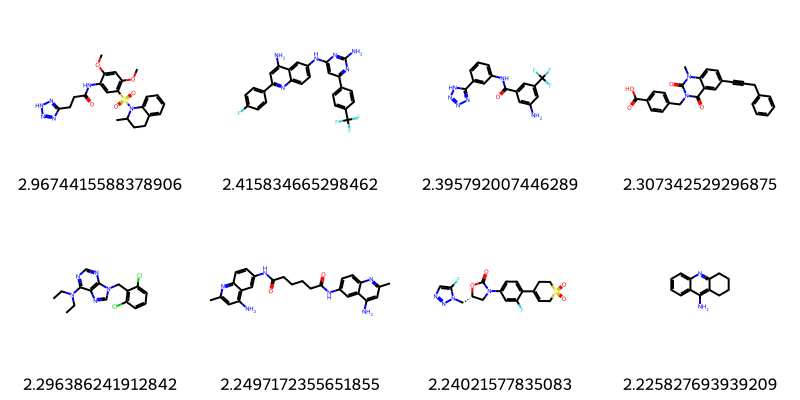

In [209]:
img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=[str(x) for x in test_res['abs_error']])
img

In [210]:
test_res.tail(8)

,pred,actual,smiles,abs_error
719,1.703763,1.70,Nc1n[nH]c2c(Cl)cccc12,0.003762
419,2.403123,2.40,CCOc1ccc2nc(N)sc2c1,0.003123
700,2.326921,2.33,C1Cc2ncc(c3ccc4OCCOc4c3)n2C1,0.003079
738,3.217683,3.22,C[C@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4cc...,0.002317
112,0.288497,0.29,COc1ccc(cc1)c2cc(ccc2OCC(=O)O)C(F)(F)F,0.001503
94,2.549282,2.55,NC1=NN(CC1)c2cccc(c2)C(F)(F)F,0.000718
587,2.669349,2.67,C[C@H](NC(=O)C1(N)CCN(CC1)c2ncnc3[nH]ccc23)c4c...,0.000651
816,0.369786,0.37,COc1ccc2N=CC(=O)N(CCN3CC[C@@H](NCc4ccc5OCC(=O)...,0.000214


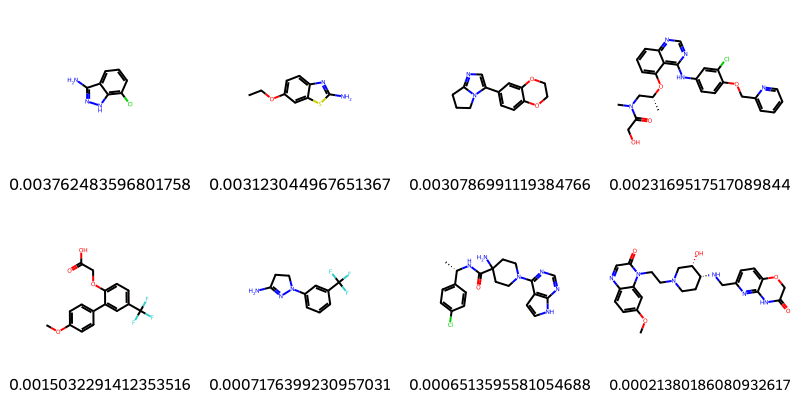

In [211]:
mols = [Chem.MolFromSmiles(x) for x in test_res['smiles'][-8:]]
img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=[str(x) for x in test_res['abs_error'][-8:]])
img

In [212]:
test_res['error'] = test_res['actual'] - test_res['pred']

In [213]:
test_res.head()

,pred,actual,smiles,abs_error,error
807,2.627442,-0.34,COc1cc(OC)c(cc1NC(=O)CCc2nn[nH]n2)S(=O)(=O)N3C...,2.967442,-2.967442
469,3.955835,1.54,Nc1cc(nc2ccc(Nc3cc(nc(N)n3)c4ccc(cc4)C(F)(F)F)...,2.415835,-2.415835
560,2.595792,0.20,Nc1cc(cc(c1)C(F)(F)F)C(=O)Nc2cccc(c2)c3nnn[nH]3,2.395792,-2.395792
453,0.192658,2.50,CN1C(=O)N(Cc2ccc(cc2)C(=O)O)C(=O)c3cc(ccc13)C#...,2.307343,2.307343
565,3.546386,1.25,CCN(CC)c1ncnc2c1ncn2Cc3c(Cl)cccc3Cl,2.296386,-2.296386


<Axes: xlabel='error', ylabel='Count'>

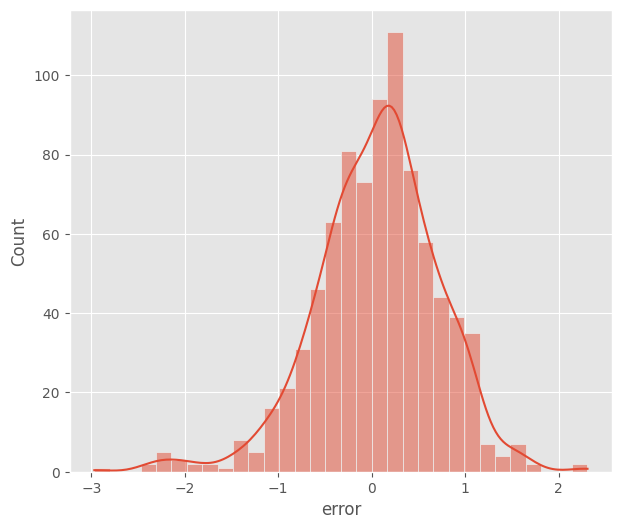

In [214]:
fig = plt.figure(figsize=(7, 6))

sns.histplot(test_res, x='error', kde=True)
